# Fraud Detection Project

In [14]:
# Import required packages/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

In [15]:
# Importing the data
df = pd.read_csv("AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [17]:
# Checking for null values in the dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [18]:
# Checking number of fraud transactions
print(df['isFraud'].value_counts())
print(df['isFlaggedFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


In [19]:
# Quantifying the data imbalance
fraud_trans_per = (df['isFraud'].value_counts()[1]/df.shape[0])*100
print(f"percentage of data containing fraud transaction: {round(fraud_trans_per,2)}%")

percentage of data containing fraud transaction: 0.13%


**Note:** Highly imbalanced data

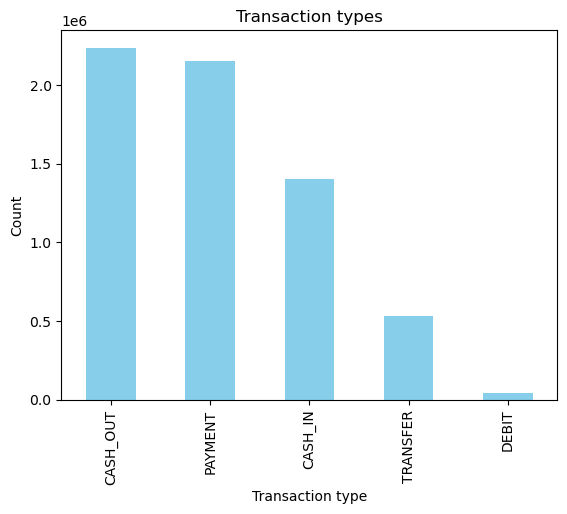

In [20]:
# Transaction type distribution
df['type'].value_counts().plot(kind = 'bar', title="Transaction types", color = "skyblue")
plt.xlabel("Transaction type")
plt.ylabel("Count")
plt.show()

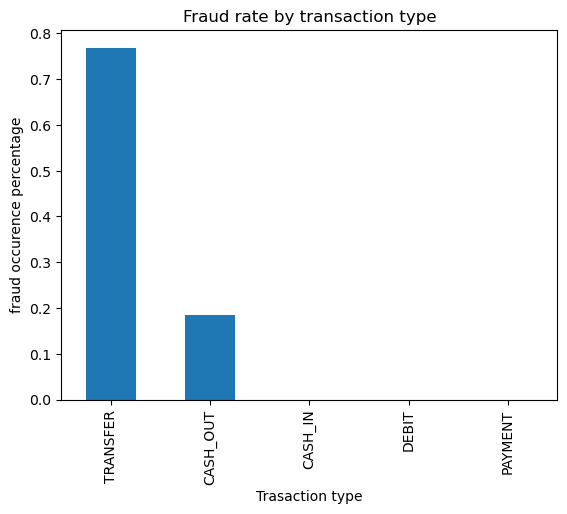

In [21]:
# Check fraud occurence in each transaction type
fraud_by_type = ((df.groupby("type")['isFraud'].mean())*100).sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud rate by transaction type")
plt.xlabel("Trasaction type")
plt.ylabel("fraud occurence percentage")
plt.show()

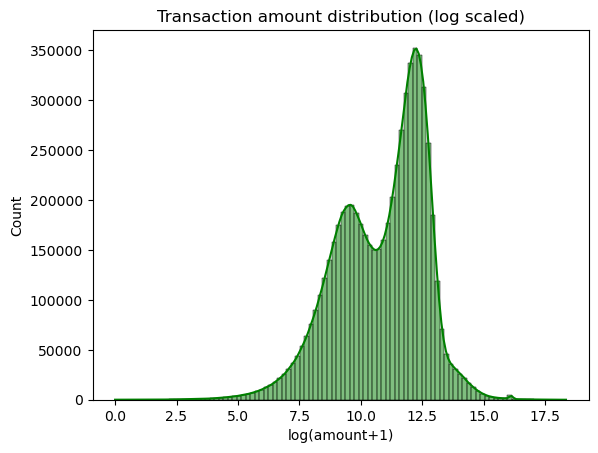

In [22]:
# Transaction amount distribution
sns.histplot(np.log1p(df['amount']), bins=100, kde=True, color='green')
plt.title("Transaction amount distribution (log scaled)")
plt.xlabel("log(amount+1)")
plt.show()

In [23]:
# Checking distribution for raw amount data
df['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

There are some large outlier amounts in the data

In [24]:
# Removing outlier before generating a box-plot for a better interpretation
q1_amount = df['amount'].quantile(0.25)
q3_amount = df['amount'].quantile(0.75)
iqr_amount = q3_amount - q1_amount
amount_outlier = q3_amount + 1.5*iqr_amount
print("amount_outlier_threshold: ", amount_outlier)

amount_outlier_threshold:  501719.33875


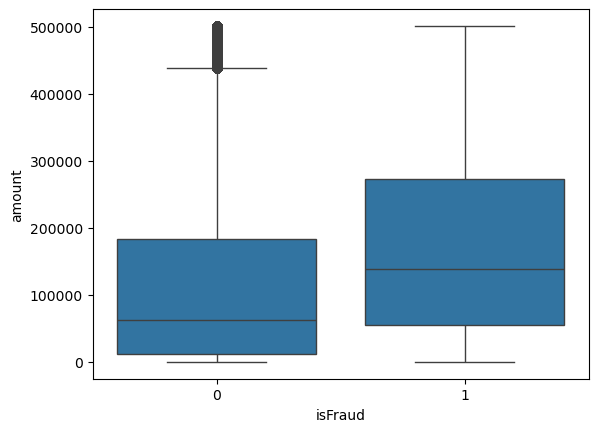

In [25]:
# Boxplot to understand amount distribution with respect to isFraud flag
sns.boxplot(data = df[df['amount'] < amount_outlier], x = 'isFraud', y = 'amount')
plt.show()

**Note:** Frauds are taking place for generally higher transactions

In [26]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [27]:
# oldbalanceOrg: Old balance of source account
# newbalanceOrig: New balance of source account
# oldbalanceDest: Old balance of destination account 
# newbalanceDest: New balance of destination account 
# oldbalanceOrg should be larger than newbalanceOrig & newbalanceDest should be larger than oldbalanceDest
print("invalid source transaction data: ", df[df['newbalanceOrig'] > df['oldbalanceOrg']].shape[0])
print("invalid destination transaction data: ", df[df['newbalanceDest'] < df['oldbalanceDest']].shape[0])

invalid source transaction data:  1399253
invalid destination transaction data:  1238864


In [28]:
top_fraud_senders = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(10)
top_fraud_recievers = df[df['isFraud'] == 1]['nameDest'].value_counts().head(10)

In [29]:
top_fraud_senders

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C1039979813    1
C2089752665    1
C1614818636    1
C40604503      1
C1970706589    1
Name: count, dtype: int64

In [30]:
top_fraud_recievers

nameDest
C967226405     2
C1601170327    2
C650699445     2
C105660024     2
C1981613973    2
C803116137     2
C505532836     2
C964377943     2
C200064275     2
C1259079602    2
Name: count, dtype: int64

**Note:** We saw that there are only two transaction types (Transfer and Cash out) consisting of fraud transactions

In [31]:
# data with only transfer and cashout transaction types
fraud_types = df[df['type'].isin(["TRANSFER", "CASH_OUT"])]

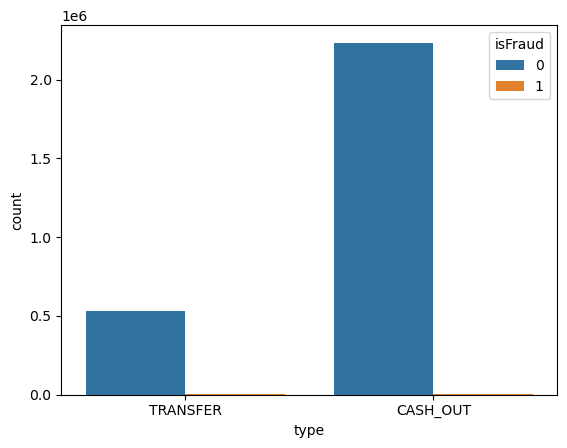

In [32]:
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.show()

In [33]:
# Getting transaction data where origin balance becomes zero after transaction
zero_after_trans = fraud_types[
    (fraud_types['oldbalanceOrg'] > 0) &
    (fraud_types['newbalanceOrig'] == 0)
    ]
len(zero_after_trans)

1188074

**Note:** "zero_after_trans" is the suspicious data

## Modelling

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [65]:
import sklearn
sklearn.__version__

'1.6.1'

In [35]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [36]:
# Dropping irrelevant columns
df_model = df.drop(["step", "nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [37]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 339.8+ MB


In [38]:
# Defining column type
categorical = ["type"]
numeric = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [39]:
# Defining the features and target variable
y = df_model['isFraud']
X = df_model.drop(['isFraud'], axis=1)

In [40]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [41]:
# Creating a preprocessing pipeline
# Dropping first category of the categorical column to avoid perfect multicolinearity (type1 = 1 - (type2 + type3))
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ],
    remainder='drop'
)

### Logistic Regression with class_weight = balanced

In [42]:
# Generating the final pipeline
# class_weight = "balanced" give more weights to errors for minority class while optimizing it
pipeline_lr = Pipeline(
    [
        ("prep", preprocessor),
        ("clf", LogisticRegression(class_weight='balanced', max_iter=1000))
    ]
)

In [43]:
# fitting the model
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [44]:
# Generating the predictions
y_pred_lr = pipeline_lr.predict(X_test)

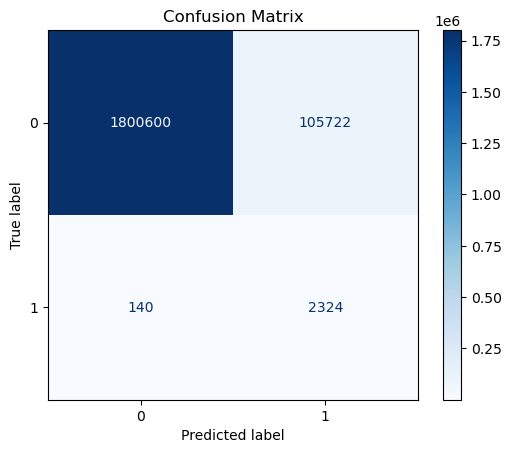

In [45]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [46]:
# Generaring the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



The above model results have high accuracy and recall but the precision is very low.

Precision = $\frac{TP}{TP + FP}$

Recall = $\frac{TP}{TP + FN}$

Low Precision means it has very high false positives (false alarms) and high recall means it has very less false negatives (missed frauds) which means the model is overestimating the positives (frauds) which can be seen by the confusion matrix. The model predicted (105228 + 2323) frauds where as there were only (141 + 2323) positives in the test data. 

The reason is "class_weight="balanced"" as it gives more weightage to the minority class.

After cheking by running without that parameter we got high precision but low recall as it predicts most of the data points as negatives, which is an expected behaviour in class imbalance case.


### Random Forest with class_weight=balanced

In [47]:
# Generating the final pipeline
from sklearn.ensemble import RandomForestClassifier
n_cores = os.cpu_count() - 2

pipeline_rfc = Pipeline(
    [
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(class_weight='balanced', n_jobs=n_cores))
    ]
)

In [48]:
# fitting the model
pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=10))])

In [49]:
# Generating the predictions
y_pred_rfc = pipeline_rfc.predict(X_test)

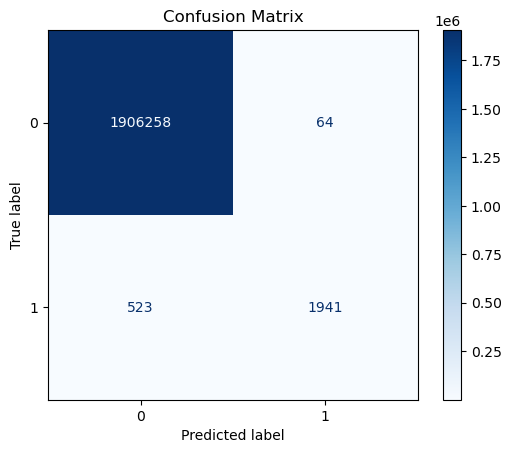

In [50]:
cm = confusion_matrix(y_test, y_pred_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [51]:
# Generaring the classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.97      0.79      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



### XGBoost with scale_pos_weight 

In [54]:
import xgboost as xgb
# Compute scale_pos_weight
scale_pos_weight = 0.1*(len(y_train[y_train==0]) / len(y_train[y_train==1])) # Reducing scale_pos_weight to reduce the penalty on FN

pipeline_xgb = Pipeline(
    [
        ("prep", preprocessor),
        ("clf", xgb.XGBClassifier(
                scale_pos_weight=scale_pos_weight,
                max_depth=6,
                n_estimators=500,
                learning_rate=0.1,
                eval_metric='aucpr',  # PR-AUC is better for extreme imbalance
                use_label_encoder=False,
                n_jobs = n_cores
        ))
    ]
)

In [55]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=10,
                               num_parallel_tree=None, ...))])

In [56]:
# Generating the predictions
y_pred_xgb = pipeline_xgb.predict(X_test)

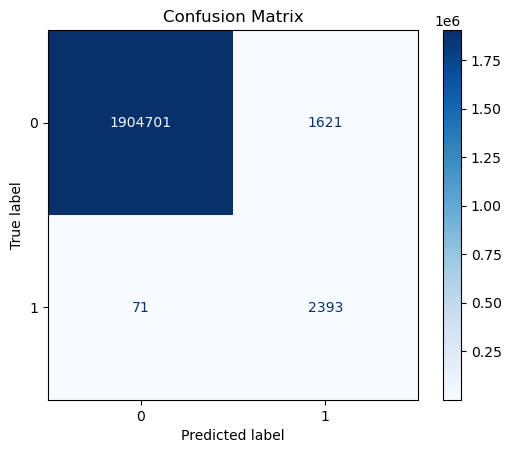

In [57]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [58]:
# Generaring the classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.60      0.97      0.74      2464

    accuracy                           1.00   1908786
   macro avg       0.80      0.99      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786



## Anomaly detection

In [59]:
# --- Isolation Forest ---
from sklearn.ensemble import IsolationForest

# Train only on non-fraud samples
X_train_nonfraud = X_train[y_train==0]

iso_pipeline = Pipeline([
    ('prep', preprocessor),
    ('iso', IsolationForest(contamination=0.013, random_state=42, n_jobs=-1))
])

iso_pipeline.fit(X_train_nonfraud)

# Predict anomalies: -1 = anomaly, 1 = normal
iso_pred = iso_pipeline.predict(X_test)
iso_pred = np.where(iso_pred == -1, 1, 0)  # 1 = fraud, 0 = normal

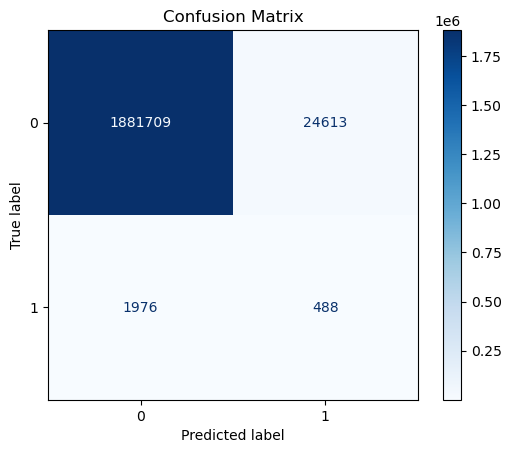

In [60]:
cm = confusion_matrix(y_test, iso_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [61]:
# Generaring the classification report
print(classification_report(y_test, iso_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1906322
           1       0.02      0.20      0.04      2464

    accuracy                           0.99   1908786
   macro avg       0.51      0.59      0.51   1908786
weighted avg       1.00      0.99      0.99   1908786



Detecting a fraud is critically important, raising a few false alarms is okay if we are able to detect most of the actual fraud cases.
Considering the above we will move forward with XGBoost as it has a very high recall (0.97), although there is still a scope of improvement on the precision (0.60) but it is the best from the above trained models

In [62]:
# Fitting the selected pipeline on the whole data
pipeline_selected = pipeline_xgb
pipeline_selected.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=10,
                               num_parallel_tree=None, ...))])

In [63]:
# Exporting the pipeline as pkl file
import joblib

joblib.dump(pipeline_selected, "fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']